In [1]:
%load_ext rich

In [2]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
import seaborn as sns

from distributions.rv import a
from distributions.continuous import A
from stats import classical, bayesian
from stats.utils import summarize

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
plt.style.use("arviz-darkgrid")

# Estudo de simulação

In [4]:
REPLICATIONS: int = 1_000
SAMPLE_SIZES: list[int] = [25, 50, 100, 200, 400]
BETAS: list[float] = [0.125, 0.6, 1.0]

In [5]:
RANDOM_SEED: int = 42
RNG: np.random.Generator = np.random.default_rng(RANDOM_SEED)

# Estudo de simulação clássico

In [6]:
betas = np.repeat(np.logspace(-2, 2, num=20), 10)
samples = np.vstack([
    a(beta=beta).rvs(size=100).mean()
    for beta in betas
]).flatten()

In [7]:
simulations = {}
np.random.seed(RANDOM_SEED)

for beta in BETAS[:1]:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        for i in range(REPLICATIONS):
            sample = rv.rvs(size=n)
            negative_log_likelihood = lambda beta_: -a(beta=beta_[0]).logpdf(sample).sum()
            simulation = classical.simulate(
                param=beta,
                negative_log_likelihood=negative_log_likelihood,
                initial_guess=0.05,
                sample_size=len(sample),
                alpha=0.05,
                method='L-BFGS-B',
                options={'gtol': 1e-6}
            )
            simulations[beta][n].append(simulation)

beta = 0.125
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400


In [8]:
summaries = pd.DataFrame([
    summarize(simulations[beta][n])
    for beta in simulations
    for n in simulations[beta]
])

In [9]:
summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.227360,0.102360,0.049155,0.527
1,0.125,50,0.181848,0.056848,0.020630,0.383
2,0.125,100,0.149499,0.024499,0.007185,0.271
3,0.125,200,0.137687,0.012687,0.003454,0.184
4,0.125,400,0.131544,0.006544,0.001724,0.105


<Axes: xlabel='sample_size', ylabel='mean'>

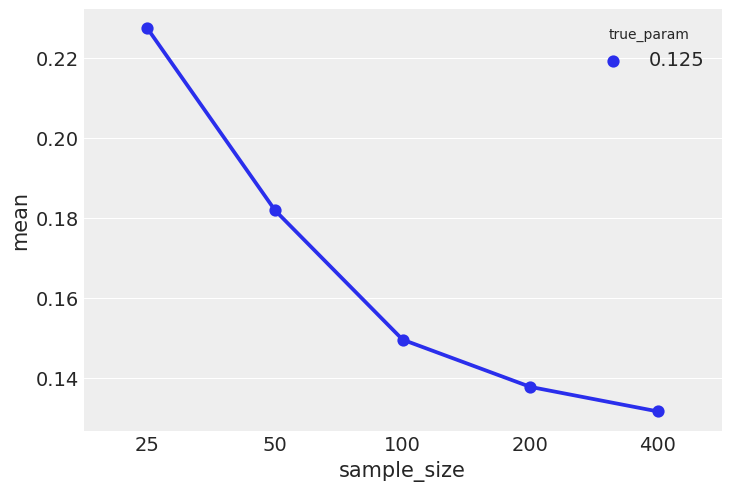

In [10]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, x="sample_size", y="mean", hue="true_param", ax=ax)

# Estudo de simulação bayesiano

```python
positive_continuous = [
    'Exponential',
    'Gamma',
    'HalfCauchy',
    'HalfFlat',
    'HalfNormal',
    'HalfStudentT',
    'InverseGamma',
    'LogNormal',
    'LogNormal',
    'PolyaGamma',
    'Rice',
    'Wald',
    'Weibull',
]
```

## Estudo das divergências

```python
np.random.seed(RANDOM_SEED)

sample = a(beta=BETAS[1]).rvs(size=SAMPLE_SIZES[0])

with pm.Model() as basic_model:
    beta = pm.Gamma("beta", alpha=1, beta=1)
    y = A("y", beta=beta, observed=sample)
```

```python
idata = {}

targets = [.80, .85, .90, .95, .99]

with basic_model:
    for target_accept in targets:
        idata[target_accept] = pm.sample(draws=5000,
                                         chains=4,
                                         tune=2000,
                                         target_accept=target_accept,
                                         return_inferencedata=True,
                                         random_seed=RNG)

pd.DataFrame({
    "step_size": [float(idata[target].sample_stats.step_size.mean()) for target in targets],
    "divergent": [float(idata[target].sample_stats.diverging.sum()) for target in targets],
    "delta_target": targets,
})
```

## Priori $\operatorname{Gama}(1, 1)$

\begin{align}
    \beta &\sim \operatorname{Gama}(1, 1) \\
    X &\sim \operatorname{A}(\beta)
\end{align}

```python
np.random.seed(RANDOM_SEED)

sample = a(beta=BETAS[0]).rvs(size=SAMPLE_SIZES[0])

with pm.Model() as basic_model:
    beta = pm.Gamma("beta", alpha=1, beta=1)
    y = A("y", beta=beta, observed=sample)
    
    
    idata = pm.sample(draws=5000,           
                      chains=4,           
                      tune=2000,           
                      target_accept=0.95,           
                      return_inferencedata=True,           
                      random_seed=RNG)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    # az.plot_ppc(idata, mean=False, observed_rug=True, num_pp_samples=100)
```

In [ ]:
simulations = {}

for beta in BETAS[:1]:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        for i in range(REPLICATIONS):
            sample = rv.rvs(size=n)
            bayesian.simulate(
                param=beta,
                sample=sample,
                prior=pm.Gamma,
                prior_params={"name": "beta", "alpha": 1, "beta": 1},
                alpha=.05,
                sampler_params={
                    "draws": 5000,           
                    "chains": 4,           
                    "tune": 2000,           
                    "target_accept": .99,           
                    "return_inferencedata": True,           
                    "random_seed": RNG
                }
            )
            simulations[beta][n].append(simulation)

In [ ]:
ax = az.plot_trace(idata)
ax = az.plot_posterior(idata)
ax.axvline(BETAS[0], color="orange")
ax.axvline(idata.posterior.beta.mean(), ls="--")

# Apêndice

In [ ]:
fig, ax = plt.subplots()

beta = 30
samples = pm.draw(A.dist(beta), 1000)
rv = a(beta=beta)

xs = np.linspace(rv.ppf(0.001), rv.ppf(0.99), num=200)
ys = rv.pdf(xs)
sns.histplot(samples, stat="density", ax=ax)
sns.lineplot(x=xs, y=ys, color="orange", ax=ax)
ax.set(xlim=(0, 50), ylim=(0,0.2))

In [ ]:
sample = a(beta=beta).rvs(100)

In [ ]:
with pm.Model() as model:
    beta = pm.Gamma("beta", 1, 1)
    y = A("y", beta=beta, observed=sample)

In [ ]:
with model:
    idata = pm.sample(draws=1000, chains=4, return_inferencedata=True)

In [ ]:
az.plot_trace(idata)

In [ ]:
az.plot_posterior(idata)

In [ ]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
ax = az.plot_ppc(idata, mean=False, observed_rug=True, num_pp_samples=100)
ax.set_xlim(0, 100)